In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares

In [4]:
def plot(image: np.ndarray, title=None, zlimit=True, **kwargs) -> None:
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    plt.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        plt.title(title)
    plt.show()

[Sat, 04 Mar 2023 12:53:16] [INFO    ] [topostats] Extracting image from Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm
[Sat, 04 Mar 2023 12:53:16] [INFO    ] [topostats] Loading image from : Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm
[Sat, 04 Mar 2023 12:53:16] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004] : Loaded image from : Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm
[Sat, 04 Mar 2023 12:53:17] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004] : Extracted channel Height
[Sat, 04 Mar 2023 12:53:17] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004] : Pixel to nm scaling : 5.815869140625


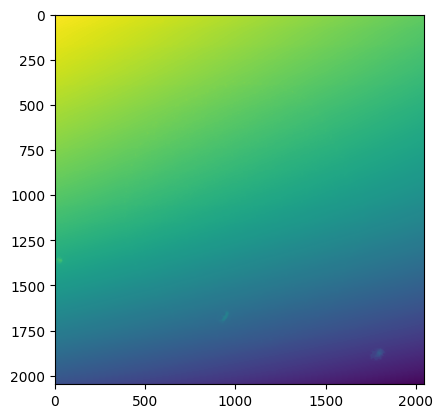

In [5]:
file = Path('./Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [6]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Sat, 04 Mar 2023 12:53:20] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm] : Median flattening without mask
[Sat, 04 Mar 2023 12:53:20] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm] : Plane tilt removal without mask
[Sat, 04 Mar 2023 12:53:20] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm] : x-polyfit 1st order: [-3.64043862e-02  3.72000135e+01]
[Sat, 04 Mar 2023 12:53:20] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm] : y-polyfit 1st order: [ 1.15093938e-19 -1.94126478e-16]
[Sat, 04 Mar 2023 12:53:20] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm] : Removing x plane tilt
[Sat, 04 Mar 2023 12:53:21] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm] : removing y plane tilt
[Sat, 04 Mar 2023 12:53:22] [INFO    ] [topostats] [Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00004.spm] : Remove quadra

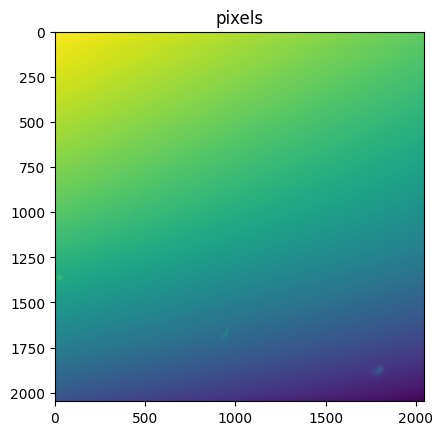

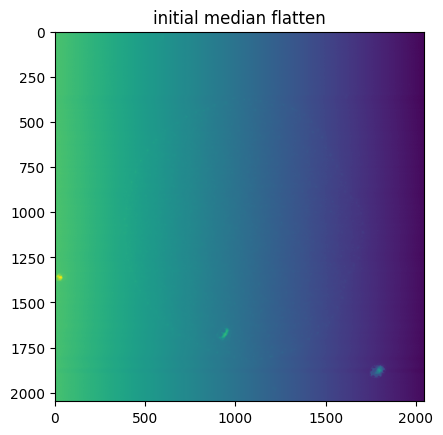

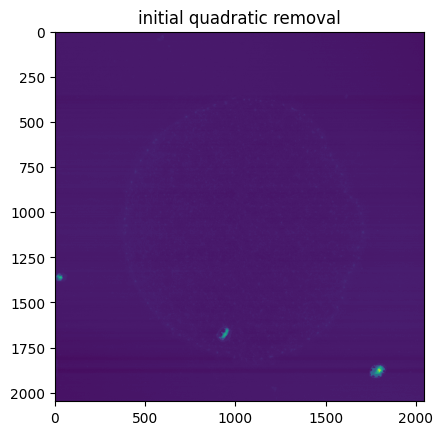

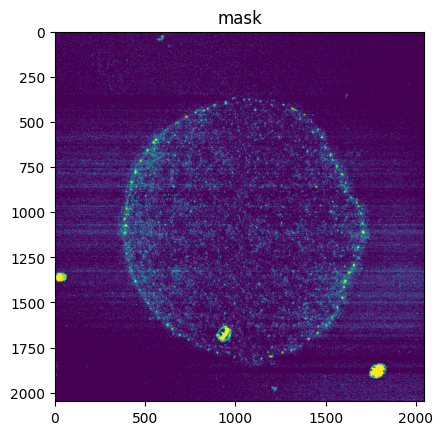

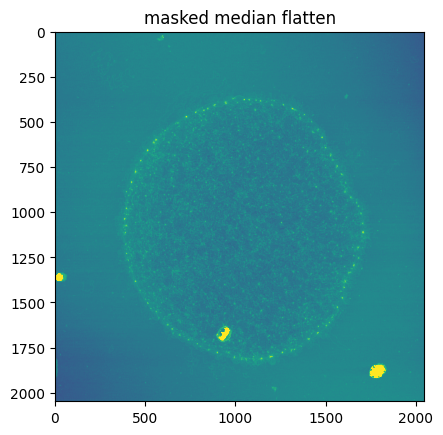

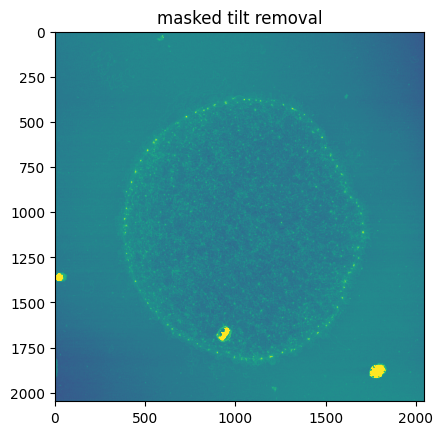

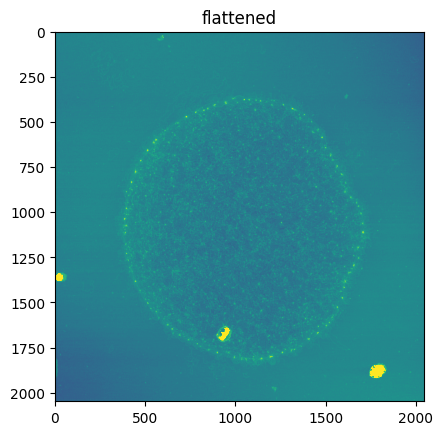

In [7]:
plot(filters.images['pixels'], title='pixels', zlimit=False)
plot(filters.images['initial_median_flatten'], zlimit=False, title='initial median flatten')
plot(filters.images['initial_quadratic_removal'], zlimit=False, title='initial quadratic removal')
plot(filters.images['mask'], title='mask', zlimit=False)
plot(filters.images['masked_median_flatten'], title='masked median flatten')
plot(filters.images['masked_tilt_removal'], title='masked tilt removal')

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened')

thresholds: defaultdict(None, {'upper': 1.6048265493738214})
[Sat, 04 Mar 2023 12:53:38] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.6048265493738214


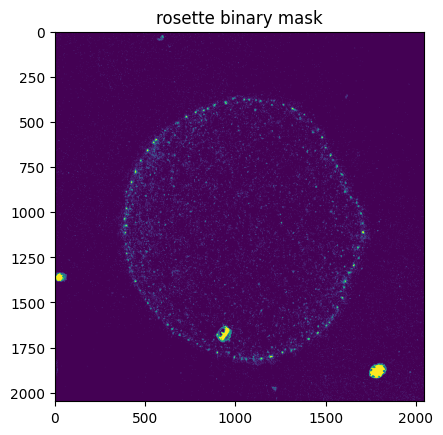

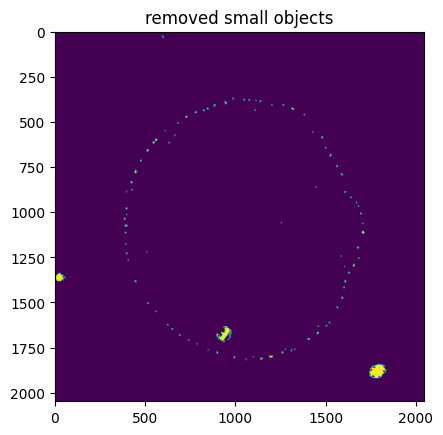

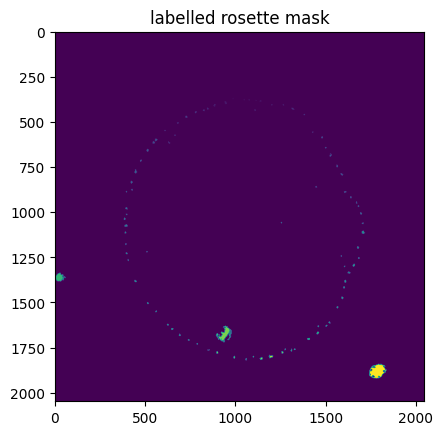

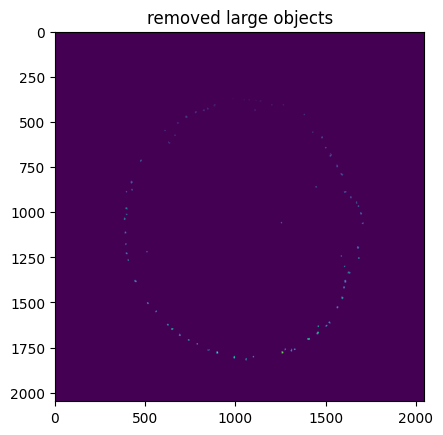

In [8]:
from skimage.morphology import remove_small_objects
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.5, 'lower': None}
)
print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask, title='rosette binary mask', zlimit=False)

# Remove small objects
rosette_mask = remove_small_objects(rosette_mask, 25)
plot(rosette_mask, title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(rosette_mask)
plot(labelled_rosette_mask, title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 100:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask, title='removed large objects', zlimit=False)


In [9]:
def ellipse_eqn(params, x, y):
    x0, y0, a, b, theta = params
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ellipse_x = ((x - x0) * cos_theta + (y - y0) * sin_theta) ** 2 / a ** 2
    ellipse_y = ((x - x0) * sin_theta - (y - y0) * cos_theta) ** 2 / b ** 2
    return ellipse_x + ellipse_y - 1

In [10]:
def ellipse_distance(params, x, y):
    x0, y0, a, b, theta = params
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ellipse_x = ((x - x0) * cos_theta + (y - y0) * sin_theta) ** 2 / a ** 2
    ellipse_y = ((x - x0) * sin_theta - (y - y0) * cos_theta) ** 2 / b ** 2
    ellipse_eqn_val = ellipse_x + ellipse_y - 1
    ellipse_grad_x = 2 * (x - x0) * cos_theta ** 2 / a ** 2 + 2 * (y - y0) * cos_theta * sin_theta / a ** 2
    ellipse_grad_y = 2 * (x - x0) * cos_theta * sin_theta / b ** 2 + 2 * (y - y0) * sin_theta ** 2 / b ** 2
    distance = np.abs(ellipse_eqn_val) / np.sqrt(ellipse_grad_x ** 2 + ellipse_grad_y ** 2)
    return distance

In [11]:
from skimage.measure import label, regionprops
def get_points(binary_img) -> tuple:
    labelled = label(binary_img)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid
    y_data = points[:, 0]
    x_data = points[:, 1]

    return (y_data, x_data)

y_data, x_data = get_points(rosette_mask)

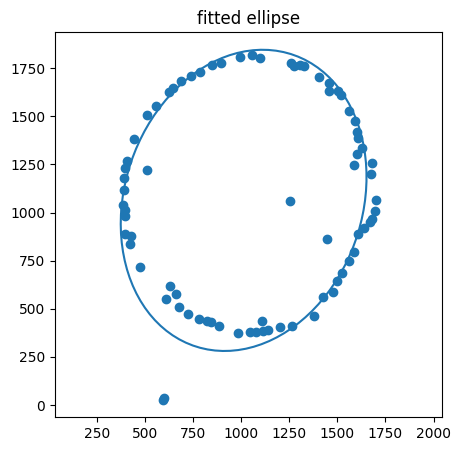

Text(0.5, 1.0, 'residuals')

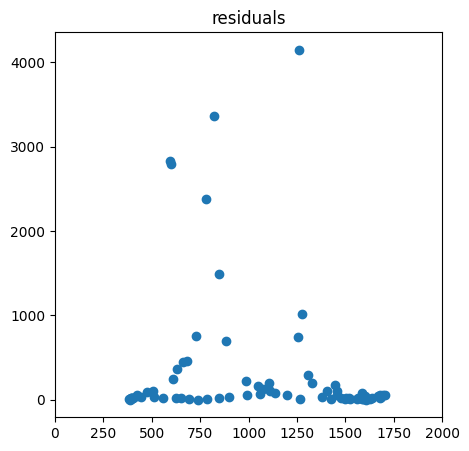

In [22]:
y_data, x_data = get_points(labelled_rosette_mask)

x_mean = np.mean(x_data)
y_mean = np.mean(y_data)
x_range = np.max(x_data) - np.min(x_data)
y_range = np.max(y_data) - np.min(y_data)
a_guess = x_range / 2
b_guess = y_range / 2
params_guess = [x_mean, y_mean, a_guess, b_guess, 0]

result = least_squares(ellipse_eqn, params_guess, args=(x_data, y_data))

x0, y0, a, b, theta = result.x
t = np.linspace(0, 2 * np.pi, 100)
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
ellipse_x = x0 + a * np.cos(t) * cos_theta - b * np.sin(t) * sin_theta
ellipse_y = y0 + a * np.cos(t) * sin_theta + b * np.sin(t) * cos_theta

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_data, y_data)
ax.plot(ellipse_x, ellipse_y)
ax.axis('equal')
plt.title('fitted ellipse')
plt.show()

# Get distances
distances = [ellipse_distance(result.x, x_val, y_val) for x_val, y_val in zip(x_data, y_data)]
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_data, distances)
ax.set_xlim(0, 2000)
plt.title('residuals')

